# Training a XResnet

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev.cli import *

In [ ]:
from spanda.data.transforms.kssl import (get_spectra_files, to_spectra, rand_w_avg, AnalytesTfm)

from pathlib import Path
from fastai.vision.all import *
from fastai.callback.hook import *
from fastai.data.all import *
from fastcore.parallel import parallel
#from tqdm import tqdm

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [ ]:
#|eval: false
path = Path('../../_data/kssl-mirs')

In [ ]:
path.ls()

(#44101) [Path('../../_data/kssl-mirs/180338'),Path('../../_data/kssl-mirs/172221'),Path('../../_data/kssl-mirs/177753'),Path('../../_data/kssl-mirs/184798'),Path('../../_data/kssl-mirs/53759'),Path('../../_data/kssl-mirs/74947'),Path('../../_data/kssl-mirs/176681'),Path('../../_data/kssl-mirs/1855'),Path('../../_data/kssl-mirs/175004'),Path('../../_data/kssl-mirs/34499')...]

In [ ]:
path.ls()[0]

Path('../../_data/kssl-mirs/180338')

In [ ]:
AnalytesTfm(analytes=[725])(path.ls()[0]).item() > 0

True

In [ ]:
def is_valid(path):
    is_analyte_pos = AnalytesTfm(analytes=[725])(path).item() > 0
    has_spectra = len(get_spectra_files(path)) > 0
    return is_analyte_pos and has_spectra

In [ ]:
%%time 
mask = parallel(is_valid, path.ls(), n_workers=8, progress=True)
paths = path.ls()[mask]

CPU times: user 6.48 s, sys: 2.47 s, total: 8.95 s
Wall time: 22 s


In [ ]:
x_tfms = [get_spectra_files, to_spectra, rand_w_avg]
y_tfms = [AnalytesTfm(analytes=[725]), torch.log10]

In [ ]:
splits = RandomSplitter(seed=42)(paths)
dsets = Datasets(paths, [x_tfms, y_tfms], splits=splits)
dls = dsets.dataloaders(bs=16, num_workers=8, drop_last=True)
dls.train.one_batch()[0].shape

torch.Size([16, 1, 1700])

In [ ]:
torch.cuda.is_available()

False

# Models

In [ ]:
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
x = dls.train.one_batch()[0]

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())

In [ ]:
learn.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,r2_score,time


KeyboardInterrupt: 

## Simple (fully-connected) NN

In [ ]:
# Most basic nn
simple_net = nn.Sequential(
        nn.Linear(1700,100),
        nn.ReLU(),
        nn.Linear(100,30),
        nn.ReLU(),
        nn.Linear(30,1),
        nn.Flatten(start_dim=1)
)

In [ ]:
simple_net(dls.train.one_batch()[0][:5])

Spectra([[-0.3351],
         [-0.6048],
         [-0.2940],
         [-0.3658],
         [-0.5607]], grad_fn=<AliasBackward0>)

## Simple CNN

In [ ]:
learn = Learner(dls, simple_net, loss_func=MSELossFlat(), metrics=R2Score())

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 1 x 1700)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 1 x 100        
Linear                                    170100     True      
ReLU                                                           
____________________________________________________________________________
                     32 x 1 x 30         
Linear                                    3030       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 1 x 1          
Linear                                    31         True      
____________________________________________________________________________
                     32 x 1              
Flatten                                                        
____________________________________________________________________________

Total params: 173,161
Total trainab

SuggestedLRs(valley=0.0003981071640737355)

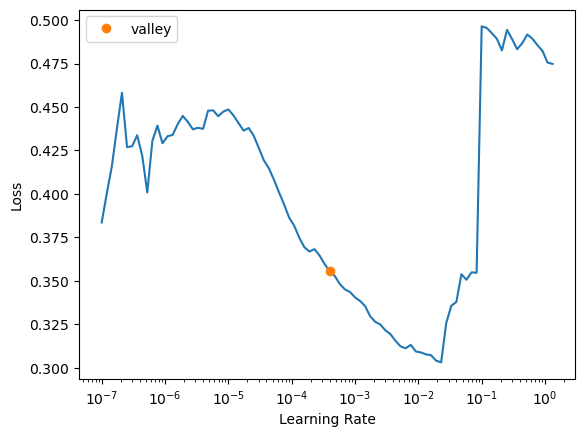

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 5e-4)

epoch,train_loss,valid_loss,r2_score,time
0,0.152352,0.172690,0.224175,03:19
1,0.130711,0.131550,0.409003,03:13
2,0.127104,0.127763,0.426014,03:08
3,0.123025,0.120469,0.458783,03:09
4,0.116849,0.117912,0.470269,03:08


## Simple ConvNet

In [ ]:
def conv(ni, nf, ks=3, s=4, act=True):
    res = nn.Conv1d(ni, nf, kernel_size=ks, stride=s, padding=ks//2) 
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [ ]:
def conv_formula(n, ks, p, s):
    return 1 + ((n+2*p-ks)//s)

conv_formula(425, 3, 1, 4)

In [ ]:
simple_cnn = sequential(
    conv(1, 4), # 425
    conv(4, 16), # 107
    conv(16, 32), # 27
    conv(32, 64), # 7
    conv(64, 128), # 2
    conv(128, 256), # 1
    conv(256, 1, act=False), #1x1
    Flatten(),
  )

In [ ]:
learn = Learner(dls, simple_cnn, loss_func=MSELossFlat(), 
                metrics=R2Score(), cbs=ActivationStats(with_hist=True))

In [ ]:
learn.summary()

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


Sequential (Input shape: 32 x 1 x 1700)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 4 x 425        
Conv1d                                    16         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 16 x 107       
Conv1d                                    208        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 32 x 27        
Conv1d                                    1568       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 7         
Conv1d                                    6208       True      
ReLU                                             

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


SuggestedLRs(valley=0.0063095735386013985)

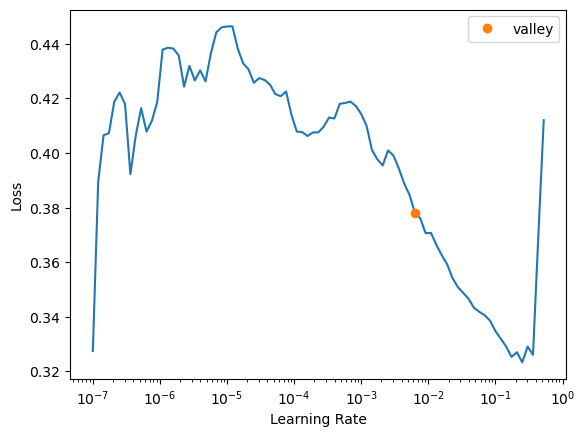

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 6e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.154995,0.140328,0.369565,03:25
1,0.131312,0.126545,0.431488,03:24
2,0.127171,0.124790,0.439372,03:26
3,0.108802,0.114363,0.486215,03:25
4,0.109963,0.111734,0.498025,03:26


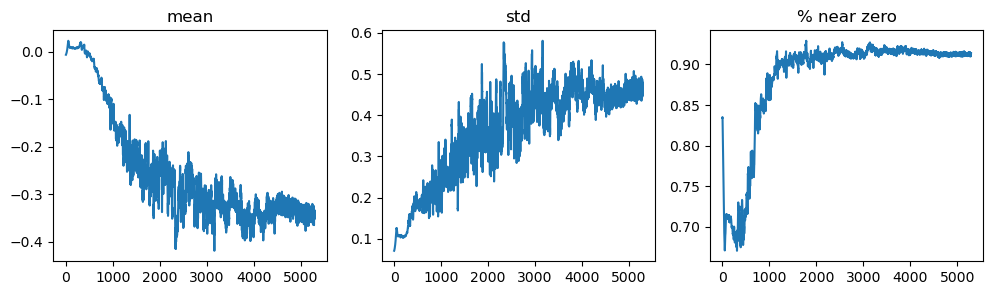

In [ ]:
learn.activation_stats.plot_layer_stats(3)

In [ ]:
learn.activation_stats.color_dim(0)

## Simple ConvNet + BN

In [ ]:
def conv(ni, nf, ks=5, s=3, act=True):
    layers = [nn.Conv1d(ni, nf, stride=s, kernel_size=ks, padding=ks//2)] 
    layers.append(nn.BatchNorm1d(nf))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [ ]:
simple_cnn = sequential(
    conv(1, 4), # 425
    conv(4, 16), # 107
    conv(16, 32), # 27
    conv(32, 64), # 7
    conv(64, 128), # 2
    conv(128, 256), # 1
    conv(256, 512), # 1
    conv(512, 1, act=False), #1x1
    Flatten(),
  )

In [ ]:
def conv_formula(n, ks, p, s):
    return 1 + ((n+2*p-ks)//s)

conv_formula(1700, ks=7, p=5//2, s=4)

425

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, in_channel=1, out_channel=16, is_classifier=False,
                 dropout=0.4):
        super(Model, self).__init__()
        # Build the neural network
        self.feature_extractor = nn.Sequential(
            self.make_convpool_block(in_channel, out_channel),
            self.make_convpool_block(out_channel, out_channel*2),
            self.make_convpool_block(out_channel*2, out_channel*4),
            self.make_convpool_block(out_channel*4, out_channel*8),
            self.make_convpool_block(out_channel*8, out_channel*16))

        num_features_before_fcnn = reduce(operator.mul,
                                          self.feature_extractor(torch.rand(1, in_channel, input_dim)).shape)

        output_layers = [nn.Dropout(dropout),
                         nn.Linear(in_features=num_features_before_fcnn, out_features=20),
                         nn.BatchNorm1d(20),
                         nn.LeakyReLU(0.1),
                         nn.Linear(in_features=20, out_features=1)];

        if is_classifier:
            output_layers.append(nn.Sigmoid())

        self.output_block = nn.Sequential(*output_layers)

    def make_convpool_block(self, input_channels, output_channels, kernel_size=3, stride=1):
        return nn.Sequential(
            nn.Conv1d(input_channels, output_channels, kernel_size, bias=False),
            nn.BatchNorm1d(output_channels),
            nn.LeakyReLU(0.1),
            nn.AvgPool1d(3))

    def forward(self, x):
        batch_size = x.size(0)
        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.output_block(out)
        return out

In [ ]:
learn = Learner(dls, Model, loss_func=MSELossFlat(), 
                metrics=R2Score(), cbs=ActivationStats(with_hist=True))

In [ ]:
learn.summary()

TypeError: children() missing 1 required positional argument: 'self'

In [ ]:
learn.lr_find()

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/_tensor.py:1278: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([448])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


RuntimeError: The size of tensor a (448) must match the size of tensor b (32) at non-singleton dimension 0

In [ ]:
learn.fit_one_cycle(40, 6e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.331749,0.269483,-0.210674,03:18
1,0.107131,0.110955,0.501527,19:19
2,0.119243,0.107768,0.515845,18:43
3,0.121631,0.110883,0.501850,03:12
4,0.113165,0.117585,0.471742,03:15
5,0.100705,0.116399,0.477068,03:14
6,0.108745,0.094337,0.576183,03:13
7,0.098884,0.095442,0.571221,03:13
8,0.108580,0.147478,0.337445,03:13
9,0.100662,0.105020,0.528188,03:15


KeyboardInterrupt: 

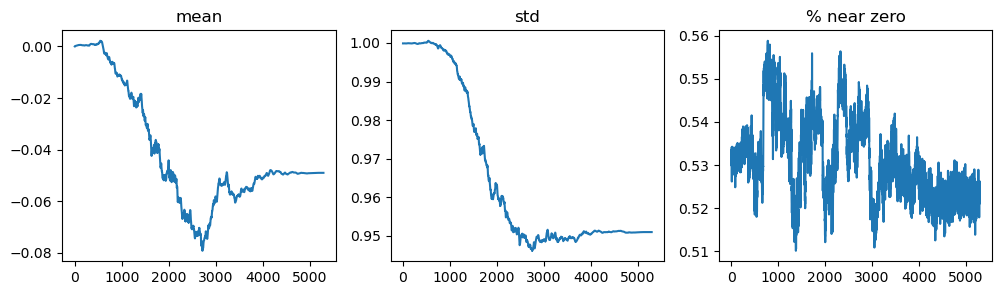

In [ ]:
learn.activation_stats.plot_layer_stats(3)

In [ ]:
model = xresnet18(ndim=1, c_in=1, ks=15, n_out=1)
x = dls.train.one_batch()[0]
model(x)